In [2]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from tqdm import tqdm
from quetzal.model import stepmodel
from syspy.skims import skims
from quetzal.io import excel

# Emissions modelling
## Saves emissions from passenger transport
## Needs inner- and intra-zonal passenger kilometer by mode

In [4]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

In [5]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

### Load results

In [5]:
sm = stepmodel.read_json(model_path + scenario + '/' + 'de_assignment')

In [6]:
# Filter unused road links
sm.road_links = sm.road_links.loc[~sm.road_links.isna().any(axis=1)]
sm.road_links.sample()

,a,b,maxspeed,length,time,"('Fz1', 'car')","('Fz2', 'car')","('Fz3', 'car')","('Fz4', 'car')","('Fz6', 'car')","('all', 'car')",geometry,lanes
index,,,,,,,,,,,,,
rl_453978,366627910,307638910,80,71,3,1.725610e+06,99779.999501,1.272081e+06,1.762230e+06,3.767625e+06,8.627326e+06,"LINESTRING (9.24846 48.61833, 9.24822 48.61896)",2


In [7]:
# Import bugfix
#segments = [('Fz'+str(p), car) for p in [1,2,3,4,6] for car in [0,1]]
segments = ['Fz'+str(p) for p in [1,2,3,4,6]]
#column_dict = {"(('"+seg[0]+"', "+str(seg[1])+"), 'car')": (seg, 'car') for seg in segments}
column_dict = {"('"+seg+"', 'car')": (seg, 'car') for seg in segments}
sm.road_links = sm.road_links.rename(columns=column_dict)

In [8]:
# Calculate vehicle kilometers by demand segment
# As done in model_assignment_inner-zone
occ_dict = params['car_occ'] # MiD2017 data, see cal10
sm.road_links['vkm'] = 0
for seg in segments:
    sm.road_links['vkm'] += sm.road_links[(seg, 'car')] * sm.road_links['length']/1000 / occ_dict[seg]#[0]]
sm.road_links['vkm'] = sm.road_links['vkm'].astype(int)

In [9]:
# Create a DataFrame to map road links to a zone
road_geo = gpd.GeoDataFrame({'NUTS1': [np.nan]*len(sm.road_links)},
                            index=sm.road_links.index,
                            geometry=[shapely.geometry.Point(g.coords[0])
                                      for g in sm.road_links['geometry']],
                            crs=sm.epsg)

In [10]:
# Load zone geometries
zones = gpd.read_file("../input_static/spatial_NUTS_RG_01M_2016_4326.geojson")
zones = zones[(zones["CNTR_CODE"]=="DE") & (zones["LEVL_CODE"]==1)]

In [11]:
# Map
shapely.speedups.enable()
for _, zone in tqdm(zones.iterrows(), total=zones.shape[0]):
    road_geo.loc[road_geo['geometry'].within(zone['geometry']), 'NUTS1'] = zone['NUTS_ID']

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [01:53<00:00,  7.11s/it]


In [12]:
# Sum up vkm by region and speed limit
merged = sm.road_links.merge(road_geo['NUTS1'], left_index=True, right_index=True)
inter_car = merged.groupby(['NUTS1', 'maxspeed']).agg({'vkm': 'sum'})
inter_car.head()

vkm
NUTS1 maxspeed              
DE1   30        5.531450e+07
      40        6.998861e+08
      50        3.199472e+09
      57        4.694924e+09
      60        2.351641e+08

In [13]:
# Generate length for PT links if not done yet
if 'length' not in sm.loaded_links.columns:
    sm.loaded_links['length'] = skims.distance_from_geometry(
        sm.loaded_links['geometry']).astype(int)

In [14]:
# Emissions from PT are considered in the service's origin
node_dict = sm.loaded_nodes['FID'].str[:3].to_dict()
sm.loaded_links['NUTS1'] = sm.loaded_links['a'].map(node_dict)
sm.loaded_links['pkm'] = sm.loaded_links['length']/1000 * sm.loaded_links['load']
inter_pt = sm.loaded_links.groupby(['NUTS1', 'route_type']).agg({'pkm': 'sum'})
inter_pt.head()

pkm
NUTS1 route_type              
DE1   air         1.904488e+08
      bus         1.986740e+09
      coach       1.703237e+09
      rail_long   4.455858e+09
      rail_short  5.064301e+09

In [15]:
# Load results of inner-zonal traffic
inner = pd.read_excel(output_path + 'inner_zone.xlsx', sheet_name='agg', index_col=[0,1])

In [16]:
inner = inner.rename(index={'rail': 'rail_short'})

In [17]:
# Combine results
merged['pkm'] = merged["('all', 'car')"] * merged['length']/1000
merged['route_type'] = 'car'
all_pkm = merged.groupby(['NUTS1', 'route_type']).agg({'pkm': 'sum'}).append(inter_pt)
inner.index.rename(['NUTS1', 'route_type'], inplace=True)
all_pkm = all_pkm.merge(inner['pkm'], how='outer', left_index=True,
                        right_index=True, suffixes=['_inter', '_inner']).fillna(0)
all_pkm['pkm'] = all_pkm['pkm_inter'] + all_pkm['pkm_inner']

array([<AxesSubplot:ylabel='None'>], dtype=object)

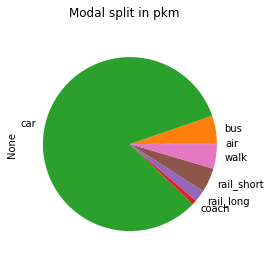

In [18]:
all_pkm['pkm'].unstack().sum(axis=0).plot.pie(subplots=True, title='Modal split in pkm')

In [19]:
# Mode shares in percent
mode_agg = {'tram': 'bus', 'subway': 'bus', 'ferry': 'bus', 'funicular': 'bus', 'coach': 'bus',
            'rail_long': 'rail', 'rail_short': 'rail'}
total = all_pkm['pkm'].sum()
all_pkm.rename(index=mode_agg).groupby(level=1).agg({'pkm': 'sum'})/total*100

,pkm
route_type,
air,0.112504
bus,6.055182
car,82.570418
rail,6.684984
walk,4.576912


In [20]:
# Total traffic (billion pkm)
total/1e9

1320.1974934396337

In [21]:
# Mode shares in total (billion pkm)
all_pkm.rename(index=mode_agg).groupby(level=1).agg({'pkm': 'sum'})/1e9

,pkm
route_type,
air,1.485274
bus,79.940366
car,1090.092593
rail,88.254986
walk,60.424275


In [22]:
# Merge car vkm
car_vkm = inner.xs('car', level=1)[['vkm']].merge(
    inter_car.groupby(level=0).sum()['vkm'], how='outer', left_index=True,
    right_index=True, suffixes=['_inner', '_inter']).fillna(0)
car_vkm['vkm'] = car_vkm['vkm_inter'] + car_vkm['vkm_inner']

In [23]:
# Average vkm per year by roughly 46 Mio. cars in Germany 2017 (GENESIS database)
car_vkm['vkm'].sum() / params['vehicles']['car']

14532.9035852439

In [24]:
# thereof inner NUTS3
car_vkm['vkm_inner'].sum() / params['vehicles']['car']

4539.321812944586

In [25]:
# thereof inter NUTS3
car_vkm['vkm_inter'].sum() / params['vehicles']['car']

9993.581772299314

In [6]:
# Official values for 2017 from TREMOD
656800000000 / params['vehicles']['car']

14290.662368501919

## Calculate PT vehicle loads

While vkm of car traffic are straight forward (using average occupancies and pkm), PT vkm strongly depend on the transport supply system. They can be modelled using average occupancy factors of PT/sharing vehicles (as for private cars), or depend on vehicle circulations that are statically defined in schedules.

Absolute road PT vkm values can be retrieved from BMVI 2018, "Verkehr in Zahlen 2018/19", p. 81. Rail vkm can be generated endogenously using GTFS feeds.

Scientific thoughts regarding a thorough and computational efficient method can be found here: https://doi.org/10.1016/j.procs.2021.03.022

In [26]:
# Use PT load factors calculated from 2018 values.
# They are already included into below emission factors per pkm.

## Calculate emissions from vkm

Reference emissions for 2019 (no change compared to 2017) from passenger traffic in Germany are 164 Mio. tCO2eq * (60.8(car)+1.4(air)+0.3(rail)+XXX(bus)=65)% = 107 Mio. tCO2eq

Source: Bundesministerium für Umwelt, Naturschutz und nukleare Sicherheit (2021): Klimaschutz in Zahlen - Fakten, Trends und Impulse deutscher Klimapolitik Ausgabe 2021, p. 36

Data sources for emission factors in this model are
* vkm car: TREMOD (Transport Emission Model; underlying values come from HBEFA (Handbuch Emissionsfaktoren)): "Aktualisierung der Modelle TREMOD/TREMOD-MM für die Emissionsberichterstattung 2020 (Berichtsperiode 1990-2018)", 2020
* pkm PT: UBA (Umweltbundesamt): "Vergleich der durchschnittlichen Emissionen einzelner Verkehrsmittel im Personenverkehr in Deutschland", 2020

In [27]:
em_dict = params['emissions']

In [28]:
# Cars
# In 2017, there were 66% petrol and 33% diesel cars, rest is mainly LPG (TREMOD, p. 43)
# Take REAL average emissions in gCO2eq/km (TREMOD, p. 54)
car_em = 0.66*173.6 + 0.33*187.6 + 0.01*104
inter_car['tCO2eq'] = inter_car['vkm'] * em_dict['car'] / 1e6

In [29]:
# PT (UBA)
inter_pt['tCO2eq'] = inter_pt['pkm'] * inter_pt.index.get_level_values(1).map(em_dict) / 1e6

In [30]:
# Inner-zonal
inner['tCO2eq'] = inner['vkm'] * inner.index.get_level_values(1).map(em_dict) / 1e6

In [31]:
# Local transport emissions (mio. tonnes)
inner.groupby('route_type').agg({'tCO2eq': 'sum'}) / 1e6

,tCO2eq
route_type,
bus,0.000000
car,37.036406
rail_short,0.000000
walk,0.000000


In [32]:
# CAR: Long-distance transport emissions (mio. tonnes)
inter_car['tCO2eq'].sum()/1e6

81.53780776282814

In [33]:
# PT: Long-distance transport emissions (mio. tonnes)
inter_pt.groupby('route_type').agg({'tCO2eq': 'sum'}) / 1e6

,tCO2eq
route_type,
air,0.317849
bus,1.212029
coach,0.377456
rail_long,0.831041
rail_short,2.137608


In [34]:
# Drop speeds in car km
inter_car = inter_car.groupby(level=0).sum()
inter_car['route_type'] = 'car'
inter_car.set_index('route_type', append=True, inplace=True)

In [35]:
# Merge emissions together
all_em = inter_pt[['tCO2eq']].append(inter_car[['tCO2eq']]).append(inner[['tCO2eq']])
all_em = all_em.groupby(level=[0,1]).sum()

<AxesSubplot:xlabel='NUTS1'>

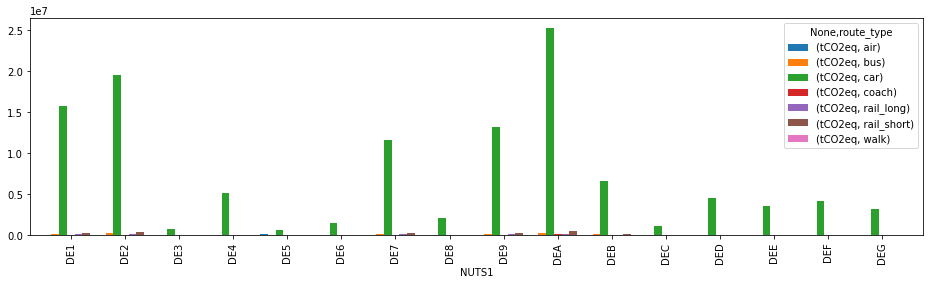

In [36]:
# Emissions by region and mode
all_em.unstack().plot.bar(subplots=False, figsize=(16,4), width=1)

## Save
Create one ecxel output with pkm, emissions, time and cost.

In [37]:
# Load inter-zonal aggregated results
inter = pd.read_excel(output_path + scenario + '/' + 'inter_zone.xlsx',
                      sheet_name='od', index_col=[0,1,2])
# Get time and price weighted averages by origin and mode
weighted_av = lambda x: np.average(x, weights=inter.loc[x.index, 'volumes'])
inter = inter.groupby(level=[0,2]).agg(
    volumes=('volumes', 'sum'),
    price=('price', weighted_av),
    time=('time', weighted_av))
inter.index.rename(['NUTS1', 'route_type'], inplace=True)

In [38]:
# Sums
for col in ['price', 'time']:
    inter[col] = inter[col] * inter['volumes']
inter.sample()

,,volumes,price,time
NUTS1,route_type,,,
DEF,car,3.955387e+08,2.633607e+09,4.196930e+08


In [39]:
# Merge times
time = inter[['time']].merge(
    (inner['time']*inner['volumes']).rename('time'), how='outer',
    left_index=True, right_index=True, suffixes=['_inter', '_inner']).fillna(0)
time['time'] = time['time_inter'] + time['time_inner']

In [40]:
# Average car operating hours per day per car
time.xs('car', level=1)['time'].sum() / params['vehicles']['car'] / 365

1.513297339953705

In [41]:
# Merge prices
price = inter[['price']].merge(
    (inner['price']*inner['volumes']).rename('price'), how='outer',
    left_index=True, right_index=True, suffixes=['_inter', '_inner']).fillna(0)
price['price'] = price['price_inter'] + price['price_inner']

In [42]:
# Save excel
with pd.ExcelWriter(output_path + scenario + '/' + 'results_agg.xlsx') as writer:  
    all_pkm.to_excel(writer, sheet_name='pkm')
    car_vkm.to_excel(writer, sheet_name='car_vkm')
    all_em.to_excel(writer, sheet_name='emissions')
    time.to_excel(writer, sheet_name='time')
    price.to_excel(writer, sheet_name='price')

### Save disaggregated results

In [43]:
# Map road volumes to NUTS3 zones as above
zones = gpd.read_file("../input_static/spatial_NUTS_RG_01M_2016_4326.geojson")
zones = zones[(zones["CNTR_CODE"]=="DE") & (zones["LEVL_CODE"]==3)]
road_geo['NUTS3'] = np.nan
for _, zone in tqdm(zones.iterrows(), total=zones.shape[0]):
    road_geo.loc[road_geo['geometry'].within(zone['geometry']), 'NUTS3'] = zone['NUTS_ID']

100%|████████████████████████████████████████████████████████████████████████████████| 401/401 [02:27<00:00,  2.71it/s]


In [44]:
# Sum up car pkm by region
merged = sm.road_links.merge(road_geo['NUTS3'], left_index=True, right_index=True)
merged['pkm'] = merged["('all', 'car')"] * merged['length']/1000
inter_car = merged.groupby('NUTS3').agg({"pkm": 'sum'})

In [45]:
# PT
node_dict = sm.loaded_nodes['FID'].to_dict()
sm.loaded_links['NUTS3'] = sm.loaded_links['a'].map(node_dict)
sm.loaded_links['pkm'] = sm.loaded_links['length']/1000 * sm.loaded_links['load']
inter_pt = sm.loaded_links.groupby(['NUTS3', 'route_type']).agg({'pkm': 'sum'})

In [46]:
# Load inner-zonal disaggregated pkm
inner = pd.read_csv(output_path + 'inner_zone_pkm.csv')
inner = inner.replace({'rail': 'rail_short'})
inner = inner.groupby(['origin', 'mode']).agg({'pkm': 'sum'})

In [47]:
# All together
inter_car['route_type'] = 'car'
inter = inter_car.groupby(['NUTS3', 'route_type']).agg({'pkm': 'sum'}).append(inter_pt)
inter.index.names = inner.index.names
all_pkm = inner.merge(inter, how='outer', left_index=True, right_index=True).fillna(0)

In [48]:
all_pkm['pkm'] = all_pkm['pkm_x'] + all_pkm['pkm_y']

In [49]:
all_pkm[['pkm']].to_csv(output_path + scenario + '/' + 'pkm.csv')